# NLP & W2VEC

In [1]:
import pandas as pd
import seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt
import json

from wordcloud import WordCloud
from pythainlp.tokenize import THAI2FIT_TOKENIZER, word_tokenize # ใช้ในการตัดคำ
from pythainlp.corpus import common # ใช้ลบคำที่ไม่ใช้ออก

from sklearn import preprocessing

# Word2Vec
from pythainlp.word_vector import WordVector
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# AI
from sklearn.model_selection import train_test_split # split data set
from sklearn.metrics import accuracy_score, classification_report # report train & test result

# AI Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Hyperparameter Tunning
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from skopt.plots import plot_objective, plot_histogram

# Saving Intelligence
from joblib import dump, load


In [2]:
data = pd.read_csv("./data/data1661832037.csv")
data = data[['message', 'category']]

In [3]:
data.head()

,message,category
0,ออ รับทราบครับ,C
1,เดี๋ยวเดือนหน้า อ.รัฐชัย จะมาสลับสอนกับผม หรือ...,T
2,เราตรวจเฉพาะงานที่ผมสั่งตอนทำแล็บนะครับ,A
3,ผมตรวจเองครับ,A
4,งานชิ้นนี้ผมต้องตรวจไหมครับ,Q


### Data Features and Values

In [4]:
category_list = data['category'].unique()
category_list

array(['C', 'T', 'A', 'Q', 'S'], dtype=object)

In [5]:
# filter common chat
data = data.drop(data.index[ data['category'] == 'C' ])
# sort data by category
data = data.sort_values(by=['category'])

data = data.reset_index()
data = data[['message', 'category']]

data.head()

,message,category
0,กรอก 3 ชั่วโมง ต่อ สัปดาห์,A
1,แบบรายงานTAเดือนกุมภาพันธ์เรียบร้อยแล้วครับ,A
2,แบบรายงานTAเดือนมกราคมเรียบร้อยแล้วครับ,A
3,จะพยายามให้นักศึกษาทำงานให้เสร็จภายในคาบ หรือห...,A
4,ผมเข้า class room แล้วนะครับ เดี๋ยวจะลองอ่านเอ...,A


In [6]:
data.shape

(118, 2)

In [7]:
data.dtypes

message     object
category    object
dtype: object

In [8]:
data.isnull().any()

message     False
category    False
dtype: bool

### Countplot of target Variable(Category)

c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='category', ylabel='count'>

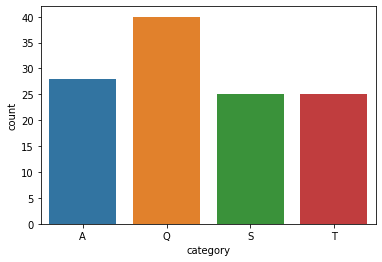

In [9]:
sns.countplot(data.category)

In [10]:
data['message_length'] = data['message'].str.len()
print(data['message_length'])

0       26
1       43
2       39
3      156
4       64
      ... 
113     44
114     43
115     30
116     15
117    123
Name: message_length, Length: 118, dtype: int64


### Words Distribution Plot

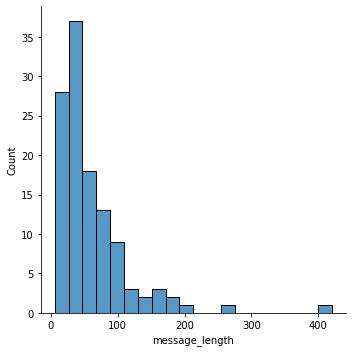

In [11]:
sns.displot(data['message_length']).set_titles('message_length')

### Count Words

In [12]:
def count_words(category=''):
    word_list = set()
    if(category != ''):
        sub_frame = data[data['category']==category]
    else:
        sub_frame = data

    for text in sub_frame['message']:
        
        text = text.lower().replace('\n', ' ').replace('\r', '').strip()
        text = re.findall(r"[\u0E00-\u0E7Fa-zA-Z']+", text)
        text = ' '.join(text)

        word_tokens = THAI2FIT_TOKENIZER.word_tokenize(text)
        filtered_sentence = set([w for w in word_tokens])

        word_list.update(filtered_sentence)

    return len(word_list)

In [13]:
words_category = []
for category in category_list:
    words_category.append(count_words(category))

words_category

[0, 243, 154, 194, 200]

In [14]:
print('Total Word:')
print(count_words())

Total Word:
493


<AxesSubplot:xlabel='category', ylabel='words_count'>

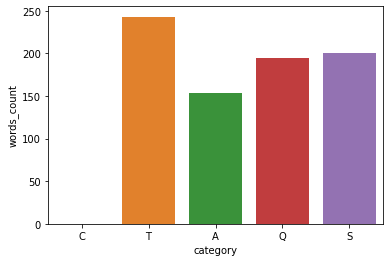

In [15]:
words_count = {'category': category_list, 'words_count': words_category}
w_count_data = pd.DataFrame(words_count)
sns.barplot(x= 'category', y='words_count', data=w_count_data)

### Word Cloud

In [16]:
def create_wordcloud(words):
    wordcloud = WordCloud(font_path='THSarabun.ttf', # path ที่ตั้ง Font
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+" # ป้องกัน bug วรรณยุกต์
                      ).generate(' '.join(THAI2FIT_TOKENIZER.word_tokenize(words)))
    plt.figure(figsize=[10, 7])
    plt.imshow(wordcloud, interpolation= "bilinear")
    plt.axis('off')
    plt.show()

In [17]:
def check_wordcloud(category):
    subset = data[data.category==category]
    text = subset.message.values
    words = ''.join(text)
    create_wordcloud(words)

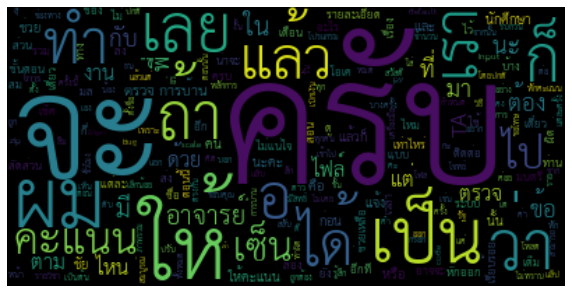

In [18]:
check_wordcloud('T')

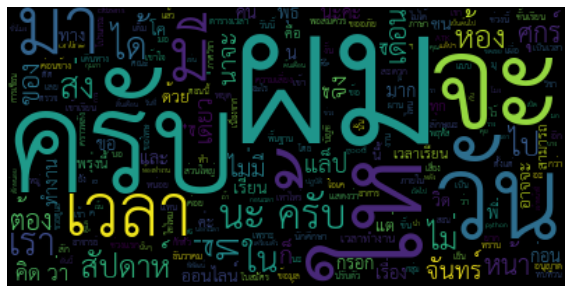

In [19]:
check_wordcloud('S')

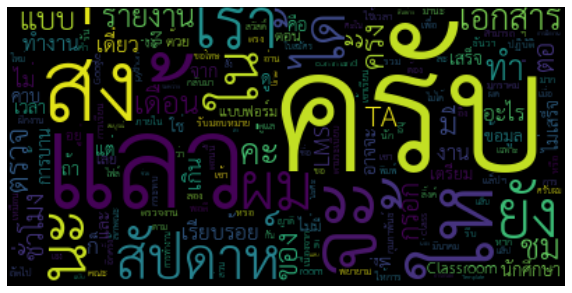

In [20]:
check_wordcloud('A')

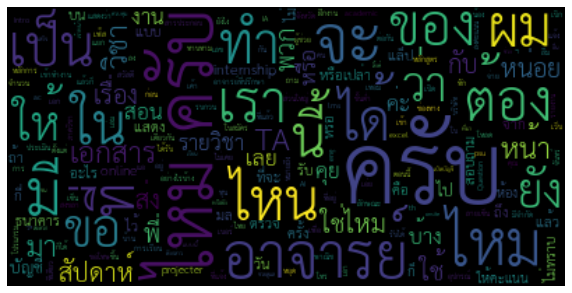

In [21]:
check_wordcloud('Q')

### Label Encoding

In [22]:
label_encoder = preprocessing.LabelEncoder()
data['category_target'] = label_encoder.fit_transform(data['category'])

In [23]:
temp_data = data[['category', 'category_target']].drop_duplicates()
print(temp_data)

   category  category_target
0         A                0
28        Q                1
68        S                2
93        T                3


In [24]:
# keep category target in json
json_classes = temp_data.to_json(orient="records")

# Writing to .json
with open("classes.json", "w") as outfile:
    outfile.write(json_classes)


   


In [25]:
# Opening JSON file
with open('classes.json', 'r') as openfile:
    # Reading from json file
    temp_json = json.load(openfile)
    print(temp_json)

[{'category': 'A', 'category_target': 0}, {'category': 'Q', 'category_target': 1}, {'category': 'S', 'category_target': 2}, {'category': 'T', 'category_target': 3}]


In [26]:
temp_json.sort(key=lambda item : item['category_target'])
print(temp_json)

[{'category': 'A', 'category_target': 0}, {'category': 'Q', 'category_target': 1}, {'category': 'S', 'category_target': 2}, {'category': 'T', 'category_target': 3}]


In [27]:
classes_list = [ item['category'] for item in temp_json]
print(classes_list)

['A', 'Q', 'S', 'T']


### Word2Vec

In [28]:
w2v_thai = WordVector()

In [29]:

word2vec = [w2v_thai.sentence_vectorizer(data['message'][i]) 
            for i in range(0,len(data['message']))]

In [30]:
X = np.array(word2vec).tolist()

data['word2vec'] = X
data_reshape = np.reshape(X, (-1, 300))

In [31]:
print(data_reshape.shape)

(118, 300)


In [32]:
data.head()

,message,category,message_length,category_target,word2vec
0,กรอก 3 ชั่วโมง ต่อ สัปดาห์,A,26,0,"[[-0.23065644088718626, -0.08037288556806743, ..."
1,แบบรายงานTAเดือนกุมภาพันธ์เรียบร้อยแล้วครับ,A,43,0,"[[-0.33973874582443386, -0.30326750106178224, ..."
2,แบบรายงานTAเดือนมกราคมเรียบร้อยแล้วครับ,A,39,0,"[[-0.33942337764892727, -0.3062093777116388, 0..."
3,จะพยายามให้นักศึกษาทำงานให้เสร็จภายในคาบ หรือห...,A,156,0,"[[-0.1547496418282944, -0.07507447682188026, 0..."
4,ผมเข้า class room แล้วนะครับ เดี๋ยวจะลองอ่านเอ...,A,64,0,"[[-0.0100752177607754, 0.0008584360146652098, ..."


# AI MODEL

### Split the data in Training and Testing

In [33]:
data_temp = [ x for x in data['word2vec']]
data_reshape = np.reshape(data_temp, (-1, 300))
data_reshape.shape


(118, 300)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(data_reshape,
                                                    data['category_target'],
                                                    test_size = 0.2,
                                                    )

In [35]:
print(X_train.shape)
print(y_train.shape)

(94, 300)
(94,)


In [36]:
print(X_test.shape)
print(y_test.shape)

(24, 300)
(24,)


### Models Predictions

In [57]:
# LinerRegression Model
l_model = LogisticRegression()
l_model.fit(X_train, y_train)
model_predictions = l_model.predict(X_test)
print('Accuracy', accuracy_score(y_test, model_predictions))
print(classification_report(y_test, model_predictions))

Accuracy 0.625
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.75      0.69      0.72        13
           2       0.50      0.67      0.57         3
           3       0.50      0.40      0.44         5

    accuracy                           0.62        24
   macro avg       0.56      0.61      0.58        24
weighted avg       0.64      0.62      0.63        24



In [38]:
# Unsupervised Model
kn_model = KNeighborsClassifier()
kn_model.fit(X_train, y_train)
model_predictions = kn_model.predict(X_test)
print('Accuracy', accuracy_score(y_test, model_predictions))
print(classification_report(y_test, model_predictions))

Accuracy 0.375
              precision    recall  f1-score   support

           0       0.14      0.33      0.20         3
           1       0.57      0.31      0.40        13
           2       0.25      0.33      0.29         3
           3       0.50      0.60      0.55         5

    accuracy                           0.38        24
   macro avg       0.37      0.39      0.36        24
weighted avg       0.46      0.38      0.39        24



In [65]:
# RandomForest Model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
model_predictions = rf_model.predict(X_test)
print('Accuracy', accuracy_score(y_test, model_predictions))
print(classification_report(y_test, model_predictions))

Accuracy 0.6666666666666666
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.79      0.85      0.81        13
           2       0.25      0.33      0.29         3
           3       0.60      0.60      0.60         5

    accuracy                           0.67        24
   macro avg       0.66      0.53      0.55        24
weighted avg       0.71      0.67      0.66        24



In [40]:
# GaussianNB Model
g_model = GaussianNB()
g_model.fit(X_train, y_train)
model_predictions = g_model.predict(X_test)
print('Accuracy', accuracy_score(y_test, model_predictions))
print(classification_report(y_test, model_predictions))

Accuracy 0.4583333333333333
              precision    recall  f1-score   support

           0       0.11      0.33      0.17         3
           1       0.83      0.38      0.53        13
           2       0.67      0.67      0.67         3
           3       0.50      0.60      0.55         5

    accuracy                           0.46        24
   macro avg       0.53      0.50      0.48        24
weighted avg       0.65      0.46      0.50        24



### Save AI Model

In [41]:
dump(l_model, './models/l_model.joblib')

['./models/l_model.joblib']

In [42]:
dump(kn_model, './models/kn_model.joblib')

['./models/kn_model.joblib']

In [43]:
dump(rf_model, './models/rf_model.joblib')

['./models/rf_model.joblib']

In [44]:
dump(g_model, './models/g_model.joblib')

['./models/g_model.joblib']

### BayesSearch Hyperparameter Tunning

In [45]:
model = KNeighborsClassifier()
opt = BayesSearchCV(
    model,
    {
        'n_neighbors': Integer(1, 20),
        'p': Integer(1, 20)
    }
    , cv=3, verbose=1, n_jobs=1
)
opt.fit(X_train, y_train)
print(opt.best_score_)
print(opt.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
0.5208333333333334
OrderedDict([('n_neighbors', 4), ('p', 10)])


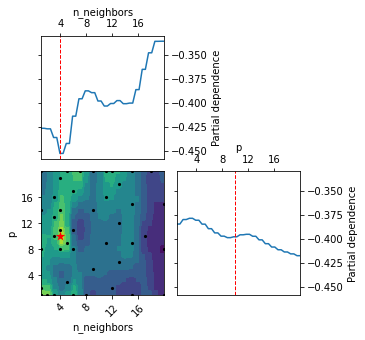

In [46]:
plot_objective(opt.optimizer_results_[0],
                   dimensions=['n_neighbors','p'],
                   n_minimum_search=int(1e8))
plt.show()

# Use Case

In [47]:
# load w2vector model and ai model
model = load('./models/l_model.joblib') 
w2v_thai = WordVector()

In [48]:
text_input = 'มีงานต้องส่งไหม'

In [49]:
test_vec = w2v_thai.sentence_vectorizer(text_input)
test_vec.shape

(1, 300)

In [50]:
output = model.predict(test_vec)
output_classes = label_encoder.classes_
output_label = output_classes[output[0]]
output_label

'Q'

# Use Case with Modules


In [51]:
from project_module.message_classifier import MessageClassifier
message_classifier = MessageClassifier()

In [52]:
message_classifier.load_model(model_path='./models/l_model.joblib', json_classes_path='./classes.json')

In [53]:
print(message_classifier.classify(text_input='อะไรนะไม่น่าจะใช่'))

S
